In [ ]:
import pandas as pd

lime_df = pd.read_csv("lime_explanations.csv")

print(lime_df.head())


                                                text  true_label  \
0  Daniel Greenfield, a Shillman Journalism Fello...           1   
1    \nI’m not an immigrant, but my grandparents ...           1   
2  The wife of the gunman who carried out the dea...           0   
3  \nThe Obamas refused to be photographed welcom...           1   
4  On September 5, 2006, Eli Chomsky was an edito...           0   

   predicted_label                                      contributions  
0                0  [('a', -0.13574181560462845), ('But', -0.09333...  
1                0  [('desecrated', -0.07274659264332786), ('among...  
2                1  [('FBI', 0.03420320068689505), ('don', 0.01825...  
3                0  [('and', -0.2045111040850175), ('The', -0.1730...  
4                1  [('election', 0.0350775019275599), ('45', 0.02...  


In [3]:
lime_df.count()

text               47
true_label         47
predicted_label    47
contributions      47
dtype: int64

In [ ]:
import ast

lime_df['contributions'] = lime_df['contributions'].apply(lambda x: ast.literal_eval(x) if isinstance(x, str) else x)


In [ ]:
import nltk
from nltk.corpus import stopwords

nltk.download("stopwords")

stop_words = set(stopwords.words("english"))

def remove_stopwords_from_contributions(df):
    filtered_contributions = []
    for contributions in df['contributions']:
        if isinstance(contributions, list):  
            filtered = [(word, importance) for word, importance in contributions if word.lower() not in stop_words]
            filtered_contributions.append(filtered)
        else:
            filtered_contributions.append(contributions)  
    df['contributions'] = filtered_contributions
    return df

lime_df = remove_stopwords_from_contributions(lime_df)

print("Stopwords eliminate. Primele 5 contribuții după procesare:")
print(lime_df['contributions'].head())


Stopwords eliminate. Primele 5 contribuții după procesare:
0    [(changed, -0.06604700518106389), (FBI, 0.0660...
1    [(desecrated, -0.07274659264332786), (among, -...
2    [(FBI, 0.03420320068689505), (said, -0.0170639...
3    [(Mr, -0.16119428670581248), (Thursday, -0.155...
4    [(election, 0.0350775019275599), (45, 0.023740...
Name: contributions, dtype: object


[nltk_data] Downloading package stopwords to
[nltk_data]     /home/vlad.cristescu/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [ ]:
false_negatives = lime_df[(lime_df['true_label'] == 0) & (lime_df['predicted_label'] == 1)]

false_positives = lime_df[(lime_df['true_label'] == 1) & (lime_df['predicted_label'] == 0)]


In [7]:
print("False positives: ", false_positives.count())
print("False negatives: ", false_negatives.count())

False positives:  text               29
true_label         29
predicted_label    29
contributions      29
dtype: int64
False negatives:  text               18
true_label         18
predicted_label    18
contributions      18
dtype: int64


In [ ]:
positive_words_fp = []
negative_words_fp = []
positive_words_fn = []
negative_words_fn = []

for contributions in false_positives['contributions']:
    if isinstance(contributions, list):  
        for item in contributions:
            if isinstance(item, tuple) and len(item) == 2 and isinstance(item[1], (int, float)):
                word, importance = item
                if importance > 0:
                    positive_words_fp.append((word, importance))
                elif importance < 0:
                    negative_words_fp.append((word, importance))
            else:
                print(f"Element invalid în FP: {item}") 

for contributions in false_negatives['contributions']:
    if isinstance(contributions, list):  
        for item in contributions:
            if isinstance(item, tuple) and len(item) == 2 and isinstance(item[1], (int, float)):
                word, importance = item
                if importance > 0:
                    positive_words_fn.append((word, importance))
                elif importance < 0:
                    negative_words_fn.append((word, importance))
            else:
                print(f"Element invalid în FN: {item}")  

positive_words_fp = sorted(positive_words_fp, key=lambda x: x[1], reverse=True)
negative_words_fp = sorted(negative_words_fp, key=lambda x: x[1])
positive_words_fn = sorted(positive_words_fn, key=lambda x: x[1], reverse=True)
negative_words_fn = sorted(negative_words_fn, key=lambda x: x[1])

print("Cele mai importante cuvinte pozitive pentru FP:")
print(positive_words_fp[:10])

print("\nCele mai importante cuvinte negative pentru FP:")
print(negative_words_fp[:10])

print("\nCele mai importante cuvinte pozitive pentru FN:")
print(positive_words_fn[:10])

print("\nCele mai importante cuvinte negative pentru FN:")
print(negative_words_fn[:10])


Cele mai importante cuvinte pozitive pentru FP:
[('Israel', 0.22291054127591556), ('Spin', 0.18757789144872417), ('NEWS', 0.154935067610888), ('op', 0.15400152381285317), ('2016', 0.14138082411153546), ('Contrary', 0.1301240929788754), ('right', 0.10305611755579375), ('Sources', 0.10302996950450301), ('Surprise', 0.10026738469758634), ('old', 0.08827943213136943)]

Cele mai importante cuvinte negative pentru FP:
[('Dublin', -0.6048847354426123), ('YORK', -0.3793825111703225), ('Doctors', -0.3372782223885648), ('told', -0.31717563320698205), ('Thursday', -0.29094738975515366), ('think', -0.2906525913893021), ('Fla', -0.22849104813437368), ('NEW', -0.17977949206294683), ('CBS', -0.17488849278931307), ('handlers', -0.17421037712852963)]

Cele mai importante cuvinte pozitive pentru FN:
[('BO', 0.28177300041820336), ('BarackObama', 0.16580304004101007), ('Trump', 0.1537484388977269), ('Trump', 0.14171827913593557), ('AP', 0.12337962281712106), ('Clinton', 0.11763789224504224), ('Photo', 0.1

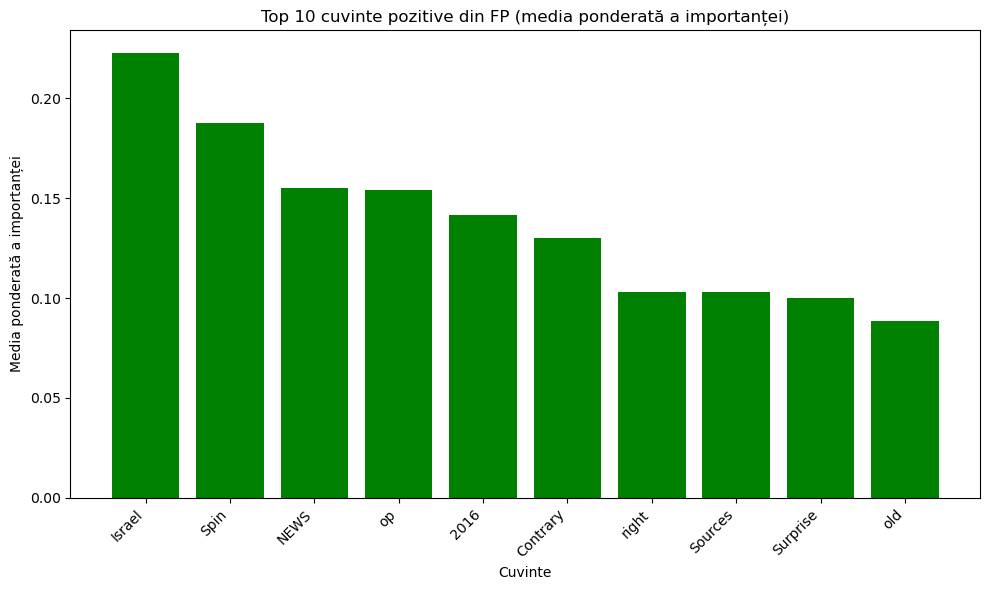

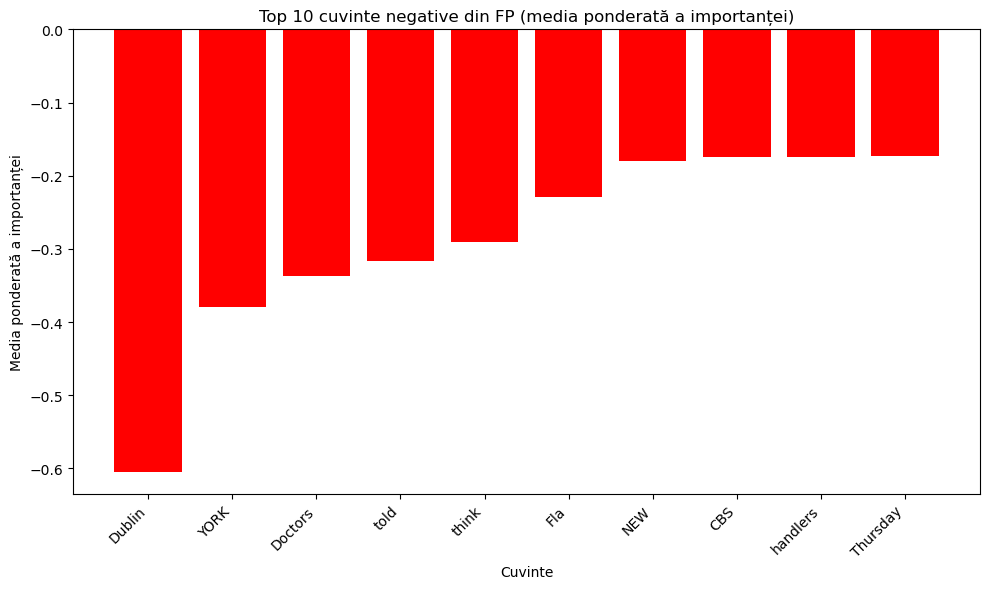

In [ ]:
import matplotlib.pyplot as plt
fp_positive_importance_sum = {}
fp_positive_count = {}

fp_negative_importance_sum = {}
fp_negative_count = {}

for contributions in false_positives['contributions']:
    if isinstance(contributions, list):  
        for word, importance in contributions:
            if isinstance(importance, (int, float)): 
                if importance > 0:  
                    if word not in fp_positive_importance_sum:
                        fp_positive_importance_sum[word] = 0
                        fp_positive_count[word] = 0
                    fp_positive_importance_sum[word] += importance
                    fp_positive_count[word] += 1
                elif importance < 0:  
                    if word not in fp_negative_importance_sum:
                        fp_negative_importance_sum[word] = 0
                        fp_negative_count[word] = 0
                    fp_negative_importance_sum[word] += importance
                    fp_negative_count[word] += 1


fp_positive_avg_importance = {
    word: fp_positive_importance_sum[word] / fp_positive_count[word]
    for word in fp_positive_importance_sum
}

fp_negative_avg_importance = {
    word: fp_negative_importance_sum[word] / fp_negative_count[word]
    for word in fp_negative_importance_sum
}

sorted_fp_positive_avg_importance = sorted(fp_positive_avg_importance.items(), key=lambda x: x[1], reverse=True)
sorted_fp_negative_avg_importance = sorted(fp_negative_avg_importance.items(), key=lambda x: x[1])

top_10_fp_positive = sorted_fp_positive_avg_importance[:10]
top_10_fp_negative = sorted_fp_negative_avg_importance[:10]

words_positive, avg_importance_positive = zip(*top_10_fp_positive)
plt.figure(figsize=(10, 6))
plt.bar(words_positive, avg_importance_positive, color="green")
plt.xticks(rotation=45, ha='right')
plt.title("Top 10 cuvinte pozitive din FP (media ponderată a importanței)")
plt.xlabel("Cuvinte")
plt.ylabel("Media ponderată a importanței")
plt.tight_layout()
plt.show()

words_negative, avg_importance_negative = zip(*top_10_fp_negative)
plt.figure(figsize=(10, 6))
plt.bar(words_negative, avg_importance_negative, color="red")
plt.xticks(rotation=45, ha='right')
plt.title("Top 10 cuvinte negative din FP (media ponderată a importanței)")
plt.xlabel("Cuvinte")
plt.ylabel("Media ponderată a importanței")
plt.tight_layout()
plt.show()


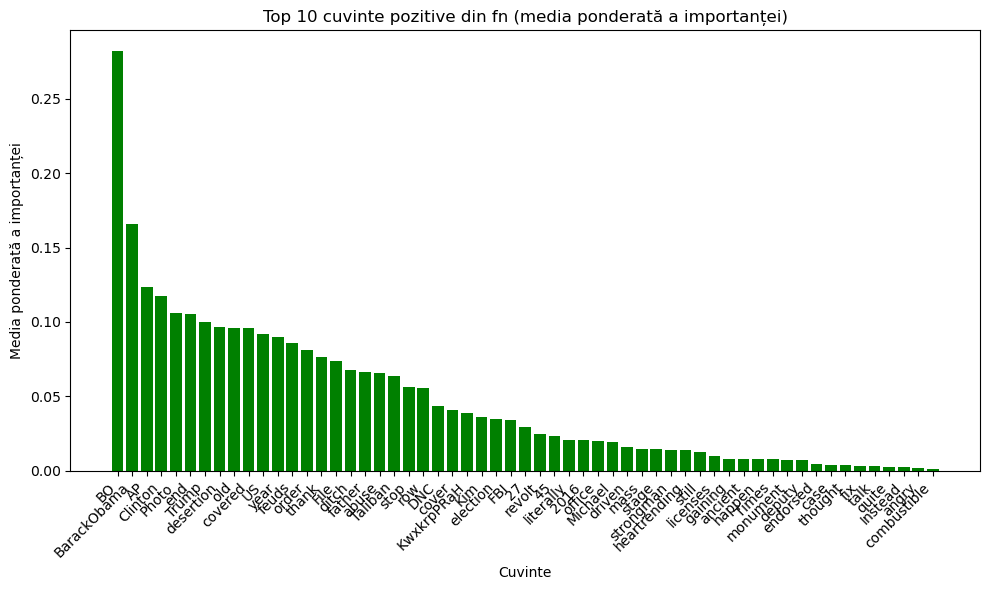

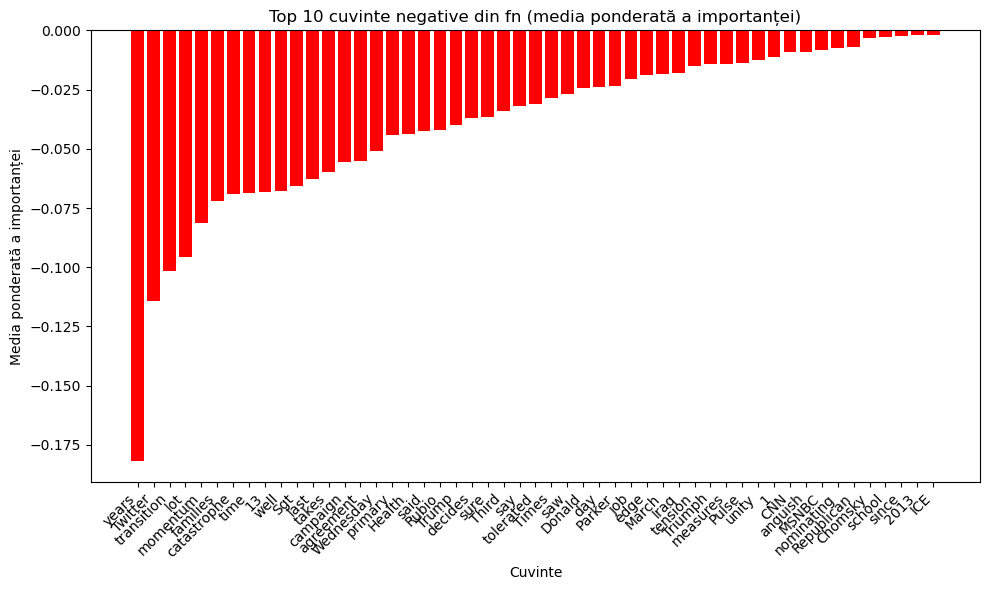

In [ ]:
import matplotlib.pyplot as plt
fn_positive_importance_sum = {}
fn_positive_count = {}

fn_negative_importance_sum = {}
fn_negative_count = {}

for contributions in false_negatives['contributions']:
    if isinstance(contributions, list):  
        for word, importance in contributions:
            if isinstance(importance, (int, float)):  
                if importance > 0:  
                    if word not in fn_positive_importance_sum:
                        fn_positive_importance_sum[word] = 0
                        fn_positive_count[word] = 0
                    fn_positive_importance_sum[word] += importance
                    fn_positive_count[word] += 1
                elif importance < 0:  
                    if word not in fn_negative_importance_sum:
                        fn_negative_importance_sum[word] = 0
                        fn_negative_count[word] = 0
                    fn_negative_importance_sum[word] += importance
                    fn_negative_count[word] += 1


fn_positive_avg_importance = {
    word: fn_positive_importance_sum[word] / fn_positive_count[word]
    for word in fn_positive_importance_sum
}

fn_negative_avg_importance = {
    word: fn_negative_importance_sum[word] / fn_negative_count[word]
    for word in fn_negative_importance_sum
}

sorted_fn_positive_avg_importance = sorted(fn_positive_avg_importance.items(), key=lambda x: x[1], reverse=True)
sorted_fn_negative_avg_importance = sorted(fn_negative_avg_importance.items(), key=lambda x: x[1])

top_10_fn_positive = sorted_fn_positive_avg_importance
top_10_fn_negative = sorted_fn_negative_avg_importance

words_positive, avg_importance_positive = zip(*top_10_fn_positive)
plt.figure(figsize=(10, 6))
plt.bar(words_positive, avg_importance_positive, color="green")
plt.xticks(rotation=45, ha='right')
plt.title("Top 10 cuvinte pozitive din fn (media ponderată a importanței)")
plt.xlabel("Cuvinte")
plt.ylabel("Media ponderată a importanței")
plt.tight_layout()
plt.show()

words_negative, avg_importance_negative = zip(*top_10_fn_negative)
plt.figure(figsize=(10, 6))
plt.bar(words_negative, avg_importance_negative, color="red")
plt.xticks(rotation=45, ha='right')
plt.title("Top 10 cuvinte negative din fn (media ponderată a importanței)")
plt.xlabel("Cuvinte")
plt.ylabel("Media ponderată a importanței")
plt.tight_layout()
plt.show()


In [ ]:

word_occurrences = {}

def update_word_occurrences(word, category):
    if word not in word_occurrences:
        word_occurrences[word] = {"FP Positive": 0, "FP Negative": 0, "FN Positive": 0, "FN Negative": 0}
    word_occurrences[word][category] += 1

for contributions in false_positives['contributions']:
    if isinstance(contributions, list):
        for word, importance in contributions:
            if importance > 0:
                update_word_occurrences(word, "FP Positive")
            elif importance < 0:
                update_word_occurrences(word, "FP Negative")

for contributions in false_negatives['contributions']:
    if isinstance(contributions, list):
        for word, importance in contributions:
            if importance > 0:
                update_word_occurrences(word, "FN Positive")
            elif importance < 0:
                update_word_occurrences(word, "FN Negative")

filtered_words = {word: counts for word, counts in word_occurrences.items() if sum(counts.values()) > 1}

for word, counts in filtered_words.items():
    print(f"Cuvânt: {word}")
    total_count = sum(counts.values())
    print(f"  Total: {total_count} (Detalii: {counts})")


Cuvânt: FBI
  Total: 2 (Detalii: {'FP Positive': 1, 'FP Negative': 0, 'FN Positive': 1, 'FN Negative': 0})
Cuvânt: election
  Total: 3 (Detalii: {'FP Positive': 2, 'FP Negative': 0, 'FN Positive': 1, 'FN Negative': 0})
Cuvânt: unity
  Total: 2 (Detalii: {'FP Positive': 0, 'FP Negative': 1, 'FN Positive': 0, 'FN Negative': 1})
Cuvânt: Thursday
  Total: 4 (Detalii: {'FP Positive': 0, 'FP Negative': 4, 'FN Positive': 0, 'FN Negative': 0})
Cuvânt: percent
  Total: 2 (Detalii: {'FP Positive': 0, 'FP Negative': 2, 'FN Positive': 0, 'FN Negative': 0})
Cuvânt: fighters
  Total: 2 (Detalii: {'FP Positive': 0, 'FP Negative': 2, 'FN Positive': 0, 'FN Negative': 0})
Cuvânt: Republican
  Total: 2 (Detalii: {'FP Positive': 0, 'FP Negative': 1, 'FN Positive': 0, 'FN Negative': 1})
Cuvânt: said
  Total: 4 (Detalii: {'FP Positive': 0, 'FP Negative': 2, 'FN Positive': 0, 'FN Negative': 2})
Cuvânt: old
  Total: 2 (Detalii: {'FP Positive': 1, 'FP Negative': 0, 'FN Positive': 1, 'FN Negative': 0})
Cuvânt: 

In [ ]:
from collections import Counter

all_positive_words = [word for word, _ in positive_words]
all_negative_words = [word for word, _ in negative_words]

positive_word_counts = Counter(all_positive_words)
negative_word_counts = Counter(all_negative_words)

print("Cele mai frecvente cuvinte pozitive:")
for word, count in positive_word_counts.most_common(10):
    print(f"{word}: {count}")

print("\nCele mai frecvente cuvinte negative:")
for word, count in negative_word_counts.most_common(10):
    print(f"{word}: {count}")

common_words = set(all_positive_words) & set(all_negative_words)
print("\nCuvinte comune între pozitive și negative:")
print(common_words)


Cele mai frecvente cuvinte pozitive:
FBI: 1
Elect: 1
op: 1
he: 1
groups: 1
2006: 1
concretely: 1
mass: 1
today: 1
Colon: 1

Cele mai frecvente cuvinte negative:
and: 2
a: 2
nominee: 2
to: 1
of: 1
the: 1
Thursday: 1
Mr: 1
The: 1
remember: 1

Cuvinte comune între pozitive și negative:
set()


# SHAP


In [ ]:
import pandas as pd

shap_df = pd.read_csv("shap_explanations.csv")

print(shap_df.count())

text               5
true_label         5
predicted_label    5
contributions      5
dtype: int64


In [ ]:
import numpy as np

positive_words = []
negative_words = []

def preprocess_contributions(contributions):
    contributions = contributions.replace("array", "np.array")
    return contributions

for contributions in shap_df['contributions']:
    try:
        print(f"Contributions raw: {contributions}")
        
        contributions = preprocess_contributions(contributions)
        
        contributions = eval(contributions)  
        
        for word, importance in contributions:
            if isinstance(importance, np.ndarray):
                importance = float(importance.sum()) 
            if importance > 0:
                positive_words.append((word, importance))
            elif importance < 0:
                negative_words.append((word, importance))
    except Exception as e:
        print(f"Eroare la procesarea contribuțiilor: {e}")
        print(f"Contributions problematice: {contributions}")



Contributions raw: [('daniel', array([ 0.01488915, -0.01488915])), ('greenfield', array([ 0.01488915, -0.01488915])), (',', array([ 0.01488915, -0.01488915])), ('a', array([ 0.01488915, -0.01488915])), ('shi', array([ 0.02037122, -0.02037122])), ('##ll', array([ 0.02037122, -0.02037122])), ('##man', array([ 0.02037122, -0.02037122])), ('journalism', array([ 0.02037122, -0.02037122])), ('fellow', array([ 0.01888038, -0.01888038])), ('at', array([ 0.01888038, -0.01888038])), ('the', array([ 0.01888038, -0.01888038])), ('freedom', array([ 0.01888038, -0.01888038])), ('center', array([ 0.01888038, -0.01888038])), (',', array([ 0.01888038, -0.01888038])), ('is', array([ 0.01888038, -0.01888038])), ('a', array([ 0.03153462, -0.03153462])), ('new', array([ 0.03153462, -0.03153462])), ('york', array([ 0.02422381, -0.02422381])), ('writer', array([ 0.02422381, -0.02422381])), ('focusing', array([ 0.01786975, -0.01786975])), ('on', array([ 0.01786975, -0.01786975])), ('radical', array([ 0.017869

In [ ]:

positive_words_sorted = sorted(positive_words, key=lambda x: x[1], reverse=True)
negative_words_sorted = sorted(negative_words, key=lambda x: x[1])

top_positive_words = positive_words_sorted[:10]
top_negative_words = negative_words_sorted[:10]

print("Cele mai importante cuvinte pozitive:")
for word, importance in top_positive_words:
    print(f"Cuvânt: {word}, Importanță: {importance}")

print("\nCele mai importante cuvinte negative:")
for word, importance in top_negative_words:
    print(f"Cuvânt: {word}, Importanță: {importance}")


Cele mai importante cuvinte pozitive:
Cuvânt: to, Importanță: 9.999999999940612e-09
Cuvânt: a, Importanță: 9.999999999940612e-09
Cuvânt: the, Importanță: 8.589999999692897e-11
Cuvânt: wife, Importanță: 8.589999999692897e-11
Cuvânt: of, Importanță: 8.589999999692897e-11
Cuvânt: the, Importanță: 8.589999999692897e-11
Cuvânt: gun, Importanță: 8.589999999692897e-11
Cuvânt: wouldn, Importanță: 1.59199999999397e-11
Cuvânt: ’, Importanță: 1.59199999999397e-11
Cuvânt: t, Importanță: 1.59199999999397e-11

Cele mai importante cuvinte negative:
Cuvânt: on, Importanță: -1.0000000001675335e-08
Cuvânt: september, Importanță: -1.0000000001675335e-08
Cuvânt: 5, Importanță: -1.0000000001675335e-08
Cuvânt: ,, Importanță: -1.0000000001675335e-08
Cuvânt: 2006, Importanță: -1.0000000001675335e-08
Cuvânt: i, Importanță: -2.3283100000002173e-11
Cuvânt: witnessed, Importanță: -2.3283100000002173e-11
Cuvânt: during, Importanță: -2.3283100000002173e-11
Cuvânt: that, Importanță: -2.3283100000002173e-11
Cuvânt: y

In [ ]:
import nltk
from nltk.corpus import stopwords

nltk.download("stopwords")

stop_words = set(stopwords.words("english"))

positive_words_filtered = []
negative_words_filtered = []

for word, importance in positive_words:
    if word.lower() not in stop_words:  
        positive_words_filtered.append((word, importance))

for word, importance in negative_words:
    if word.lower() not in stop_words:  # Ignoră stop words
        negative_words_filtered.append((word, importance))

positive_words_sorted = sorted(positive_words_filtered, key=lambda x: x[1], reverse=True)
negative_words_sorted = sorted(negative_words_filtered, key=lambda x: x[1])

top_positive_words = positive_words_sorted[:10]
top_negative_words = negative_words_sorted[:10]

print("Cele mai importante cuvinte pozitive (fără stop words):")
for word, importance in top_positive_words:
    print(f"Cuvânt: {word}, Importanță: {importance}")

print("\nCele mai importante cuvinte negative (fără stop words):")
for word, importance in top_negative_words:
    print(f"Cuvânt: {word}, Importanță: {importance}")


Cele mai importante cuvinte pozitive (fără stop words):
Cuvânt: wife, Importanță: 8.589999999692897e-11
Cuvânt: gun, Importanță: 8.589999999692897e-11
Cuvânt: ’, Importanță: 1.59199999999397e-11
Cuvânt: surprising, Importanță: 1.59199999999397e-11
Cuvânt: clinton, Importanță: 1.59199999999397e-11
Cuvânt: ##s, Importanță: 1.59199999999397e-11
Cuvânt: allies, Importanță: 1.59199999999397e-11
Cuvânt: start, Importanță: 1.59199999999397e-11
Cuvânt: running, Importanță: 1.59199999999397e-11
Cuvânt: attack, Importanță: 1.59199999999397e-11

Cele mai importante cuvinte negative (fără stop words):
Cuvânt: september, Importanță: -1.0000000001675335e-08
Cuvânt: 5, Importanță: -1.0000000001675335e-08
Cuvânt: ,, Importanță: -1.0000000001675335e-08
Cuvânt: 2006, Importanță: -1.0000000001675335e-08
Cuvânt: witnessed, Importanță: -2.3283100000002173e-11
Cuvânt: year, Importanță: -2.3283100000002173e-11
Cuvânt: iran, Importanță: -2.3283100000002173e-11
Cuvânt: changed, Importanță: -2.3283100000002173e

[nltk_data] Downloading package stopwords to
[nltk_data]     /home/vlad.cristescu/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
